<a href="https://colab.research.google.com/github/ramapriyakp/Portfolio/blob/master/Kangaroo_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Model with Keras
**Object detection** is a challenging computer vision task that involves  identifying the presence, location, and type of one or more objects in a given image.

**Object segmentation** not only involves localizing objects in the image but also specifies a mask for the image, indicating exactly which pixels in the image belong to the object.



## Setup Environment

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##  Clone the Mask R-CNN GitHub Repository

In [0]:
git clone https://github.com/matterport/Mask_RCNN.git

##  Install the Mask R-CNN Library

The library can be installed directly via pip.
Change directory into the Mask_RCNN directory and run the installation script.

In [0]:
cd '/content/gdrive/My Drive/Mask_RCNN'

/content/gdrive/My Drive/Mask_RCNN


In [0]:
!pip install -r requirements.txt
!python setup.py install

     |████████████████████████████████| 204kB 3.3MB/s 
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling bu

##Confirm Library is Installed
You can confirm that the library was installed correctly by querying it via the pip command; for example:

In [0]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


In [0]:
#import required libraries
from os import listdir
from xml.etree import ElementTree

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from matplotlib import pyplot
from matplotlib.patches import Rectangle

from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

 
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

Using TensorFlow backend.


## Prepare a Dataset for Object Detection

**Mask Region-based Convolutional Neural Network( Mask R-CNN)**
model is one of the state-of-the-art approaches for object recognition tasks. Mask R-CNN is designed to learn to predict both bounding boxes for objects as well as masks for those detected objects.

The kangaroo dataset does not provide masks. We will use the dataset to learn kangaroo object detection task, and ignore the masks and not focus on the image segmentation capabilities of the model.

 Kangaroo directory has  subdirectory called 


*   **‘images/‘** : contains all JPEG photos of kangaroos
*   **‘annotes/‘** : contains all of  XML files that describe the locations of kangaroos in each photo.The size, bounding boxes are the minimum information that we require from each annotation file.



The steps required to prepare this dataset for modeling are
*   downloading the dataset
*  parsing the annotations file 
*  developing a KangarooDataset object that can be used by the Mask_RCNN library
*  testing the dataset object to confirm that we are loading images and annotations correctly.




##Develop KangarooDataset Object
The mask-rcnn library requires that train, validation, and test datasets be managed by a **mrcnn.utils.Dataset object**.

This means that a new class must be defined that extends the mrcnn.utils.Dataset class  and defines a function to load the dataset, with any name you like such as load_dataset(), and override two functions, one for loading a mask called load_mask() and one for loading an image reference (path or URL) called image_reference(). The function details are mentioned below.

###  load_dataset()
  Custom load function responsible for  
 *  defining  classes
 *  defining images in the dataset

Classes are defined by calling the built-in add_class() function and specifying the ‘source‘ (the name of the dataset), the ‘class_id‘ or integer for the class (e.g. 1 for the first lass as 0 is reserved for the background class), and the ‘class_name‘ (e.g. ‘kangaroo‘).
`self.add_class("dataset", 1, "kangaroo")`<br>

Objects are defined by a call to the built-in add_image() function and specifying the ‘source‘ (the name of the dataset), a unique ‘image_id‘ (e.g. the filename without the file extension like ‘00001‘), and the path for where the image can be loaded (e.g. ‘kangaroo/images/00001.jpg‘).

`self.add_image('dataset', image_id='00001', path='kangaroo/images/00001.jpg', annotation='kangaroo/annots/00001.xml')`<br>

We add one more argument to define whether the Dataset instance is for training or test/validation.
We have about 160 photos, so we can use about 20%, or the last 32 photos, as a test or validation dataset and the first 131, or 80%, as the training dataset.

###image_reference()
 This function is responsible for returning the path or URL for a given ‘image_id‘,
 which we know is just the ‘path‘ property on the ‘image info‘ dict.
###load_mask() 
 This function loads mask for given ‘image_id‘.

In [0]:
# display image with masks and bounding boxes

# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/' 
    # find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
      
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

In [0]:
# prepare train set
  train_set = KangarooDataset()
  train_set.load_dataset('/content/gdrive/My Drive/Mask_RCNN/kangaroo', is_train=True)
  train_set.prepare()
  print('Train: %d' % len(train_set.image_ids))

Train: 131


In [0]:
# prepare test/val set
  test_set = KangarooDataset()
  test_set.load_dataset('/content/gdrive/My Drive/Mask_RCNN/kangaroo', is_train=False)
  test_set.prepare()
  print('Test: %d' % len(test_set.image_ids))

Test: 32


##Test KangarooDataset Object
The first useful test is to confirm that the images and masks can be loaded correctly.

(307, 550, 3)
(307, 550, 1)


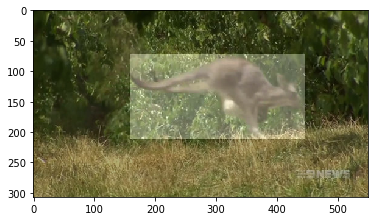

In [0]:
# load an image
 
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
pyplot.show()

Running the example shows that photos are loaded correctly and that those photos with multiple objects correctly have separate masks defined.



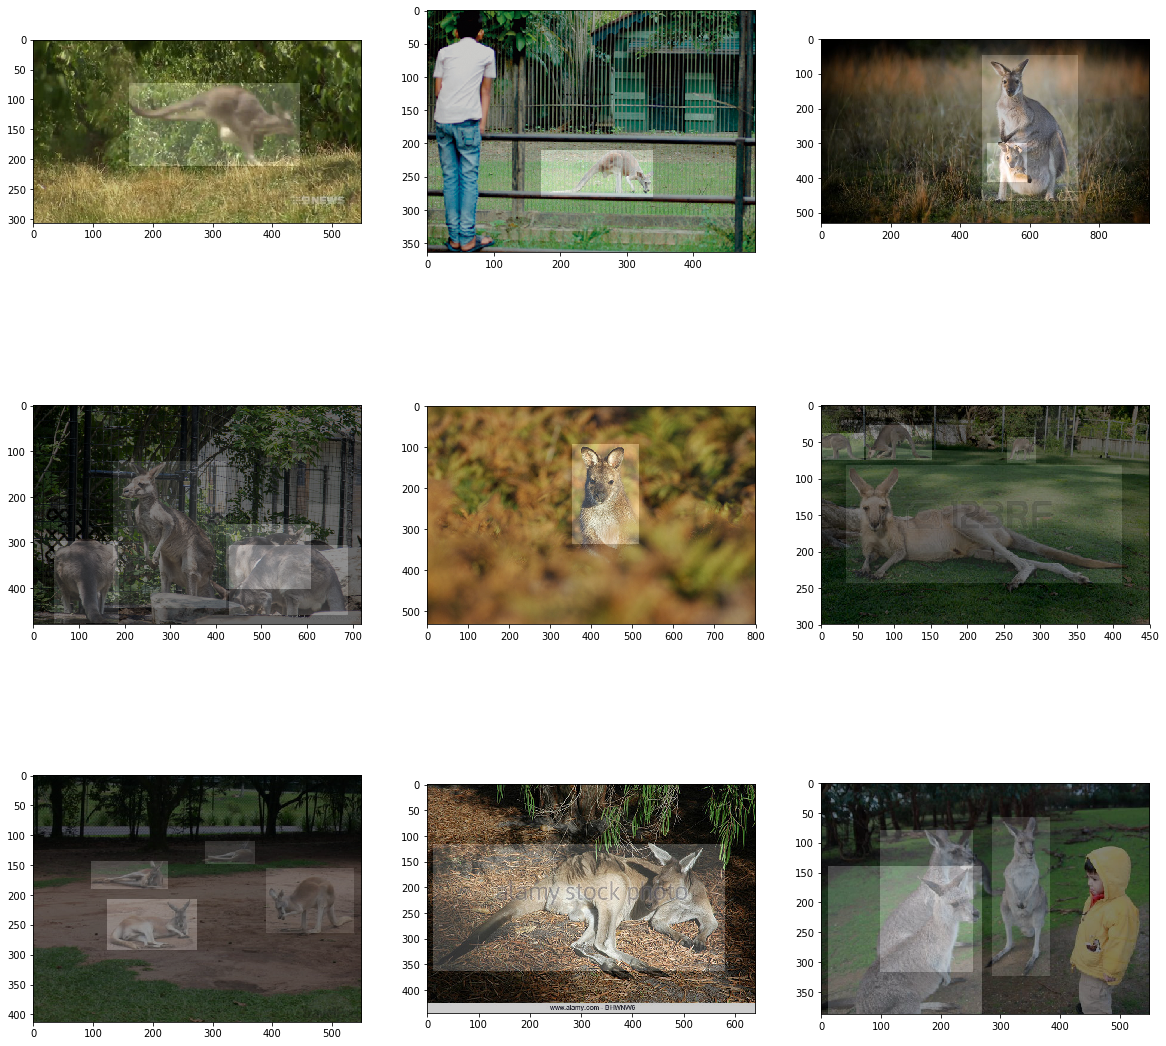

In [0]:

# plot first few images
pyplot.figure(figsize=(20,20))
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	pyplot.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.2)
# show the figure
pyplot.show()


 Finally, the mask-rcnn library provides utilities for displaying images and masks. We can use some of these built-in functions to confirm that the Dataset is operating correctly.

For example, the mask-rcnn library provides the mrcnn.visualize.display_instances() function that will show a photograph with bounding boxes, masks, and class labels. This requires that the bounding boxes are extracted from the masks via the extract_bboxes() function.


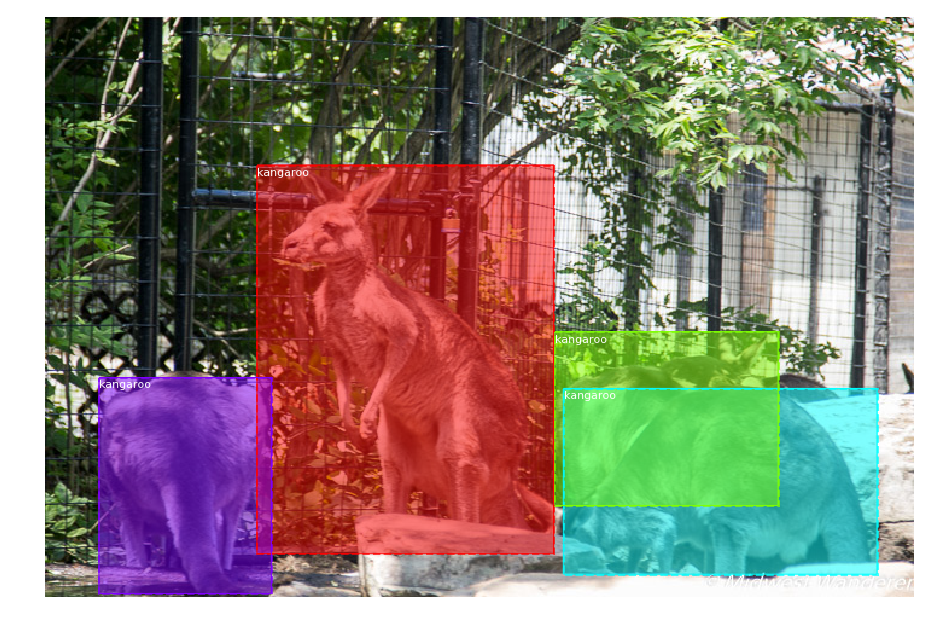

In [0]:
# define image id
image_id = 3
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

Above example creates a plot showing the photograph with the mask for each object in a separate color.

The bounding boxes match the masks exactly, by design, and are shown with dotted outlines. Finally, each object is marked with the class label, which in this case is ‘kangaroo‘.

## Train Mask R-CNN Model for Kangaroo Detection

Mask R-CNN model pre-fit on the MS COCO object detection dataset can be used as a starting point and then tailored to the kangaroo dataset.

The configuration defines name of the configuration via ‘NAME‘ attribute, e.g. ‘kangaroo_cfg‘, that will be used to save details and models to file during the run. The configuration  also define  number of classes in  prediction problem via the ‘NUM_CLASSES‘ attribute.

The number of samples (photos) used in each training epoch. This will be the number of photos in the training dataset= 131.

In [0]:
# define a configuration for the model
class KangarooConfig(Config):
  # define the name of the configuration
	NAME = "kangaroo_cfg"
 	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131


In [0]:
# prepare config
config = KangarooConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## define the model
The ‘config‘ argument must also be specified with an instance of our KangarooConfig class.

Finally, a directory is needed where configuration files can be saved and where checkpoint models can be saved at the end of each epoch. We will use the current working directory.

The model will be used as-is, although the class-specific output layers will be removed so that new output layers can be defined and trained. This can be done by specifying the ‘exclude‘ argument and listing all of the output layers to exclude or remove from the model after it is loaded. This includes the output layers for the classification label, bounding boxes, and masks.

In [0]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
Colocations handled automatically by placer.


Model can be fit on the training dataset by calling the train() function and passing in both the training dataset and the validation dataset. We can also specify the learning rate as the default learning rate in the configuration (0.001).

We can also specify what layers to train. In this case, we will only train the heads, that is the output layers of the model.

In this example where we are interested in object detection , So pay attention to the loss for the classification output on the train and validation datasets (e.g. mrcnn_class_loss and val_mrcnn_class_loss), as well as the loss for the bounding box output for the train and validation datasets (mrcnn_bbox_loss and val_mrcnn_bbox_loss).


A model file is created and saved at the end of each epoch in a subdirectory that starts with ‘kangaroo_cfg‘ followed by random characters

In [0]:

# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20190607T0528/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
131/131 [==============================] - 214s 2s/step - loss: 1.0648 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.2139 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.3905 - val_loss: 0.8451 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.2683 - val_mrcnn_class_loss: 0.0255 - val_mrcnn_bbox_loss: 0.2607 - val_mrcnn_mask_loss: 0.2809
Epoch 2/5
131/131 [==============================] - 163s 1s/step - loss: 0.6019 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1760 - mrcnn_mask_loss: 0.2431 - val_loss: 0.7603 - val_rpn_class_loss: 0.0105 - val_rpn_bbox_loss: 0.3016 - val_mrcnn_class_loss: 0.0257 - val_mrcnn_bbox_loss: 0.1715 - val_mrcnn_mask_loss: 0.2510
Epoch 3/5
131/131 [==============================] - 161s 1s/step - loss: 0.4859 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1169 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2275 - val_loss: 0.8137 - val_rpn_class_loss

## Evaluate  Mask R-CNN Model
We are predicting bounding boxes so we can determine whether a bounding box prediction is good or not based on how well the predicted and actual bounding boxes overlap. This can be calculated by dividing the area of the overlap by the total area of both bounding boxes, or the intersection divided by the union, referred to as “intersection over union,” or IoU. A perfect bounding box prediction will have an IoU of 1.

The performance of a model for an object recognition task is often evaluated using the **mean absolute precision, or mAP**

It is standard to assume a positive prediction of a bounding box if the IoU is greater than 0.5, e.g. they overlap by 50% or more.

**Precision** refers to the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all bounding boxes predicted.

**Recall** is the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all objects in the photo.

In [0]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

The average or mean of the average precision (AP) across all of the images in a dataset is called the mean average precision, or mAP.

The mask-rcnn library provides a mrcnn.utils.compute_ap to calculate the AP and other metrics for a given images. These AP scores can be collected across a dataset and the mean calculated to give an idea at how good the model is at detecting objects in a dataset.

In [0]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

evaluate_model() function calculates the mAP given a dataset, model and configuration.

evaluate the model involves enumerating the images in a dataset, making a prediction, and calculating the AP for the prediction before predicting a mean AP across all images.

Running the example will make a prediction for each image in the train and test datasets and calculate the mAP for each.

A mAP above 90% or 95% is a good score.

In [0]:
# evaluate the mask rcnn model on the kangaroo dataset


# load the train & test dataset
#load_train()
#load_test()

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('./kangaroo_cfg20190607T0528/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 5
Train mAP: 0.897
Test mAP: 0.967


## Detect Kangaroos in New Photos

We can use the trained model to detect kangaroos in new photographs, specifically, in photos that we expect to have kangaroos.

We can use any of the photos in the test dataset that were not used to train the model.

Running the example first creates a figure showing photos from  training dataset with ground truth bounding boxes, with same photo and predicted bounding boxes alongside.

Re-starting from epoch 5


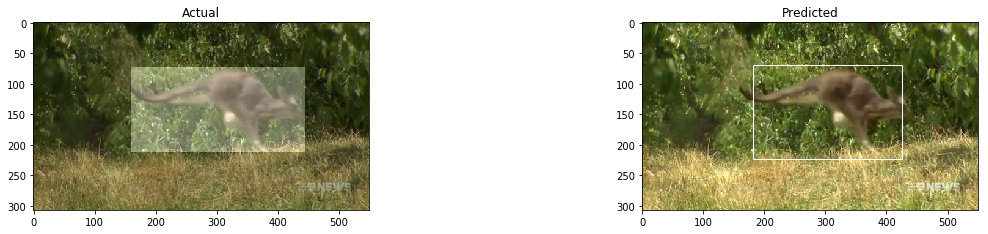

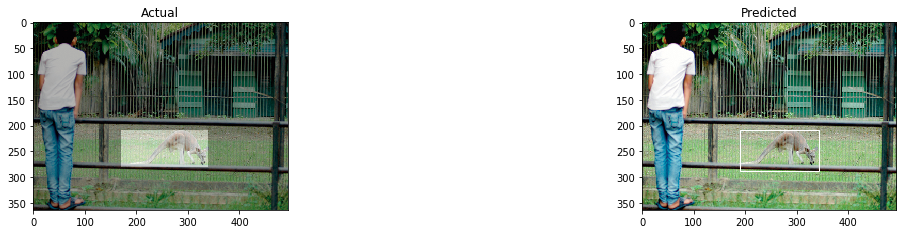

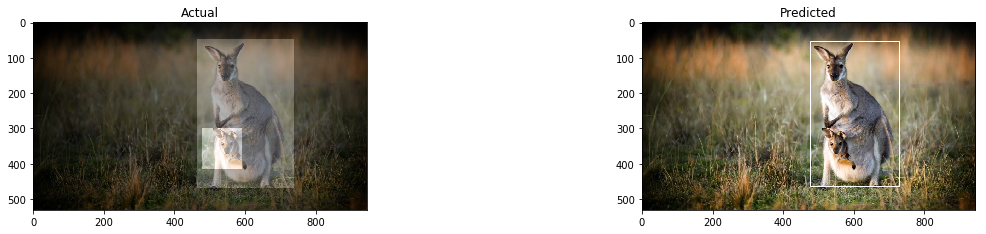

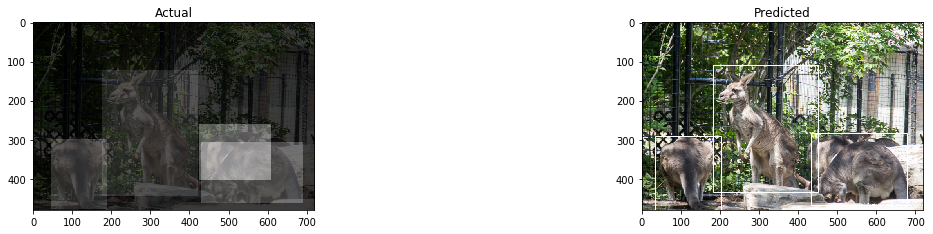

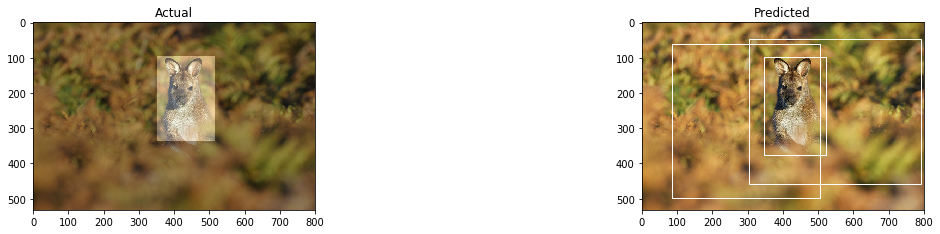

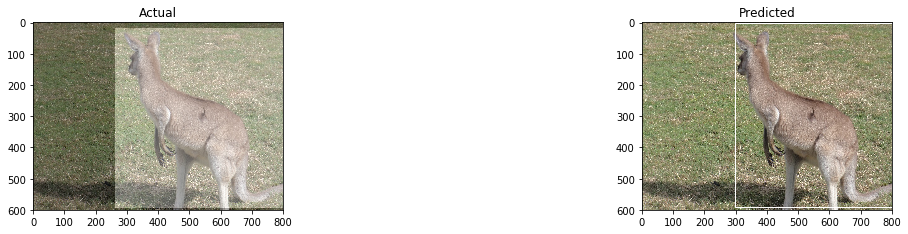

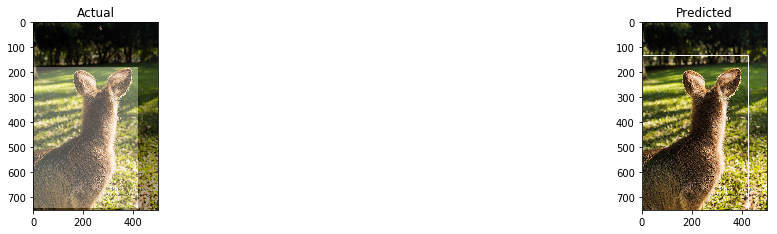

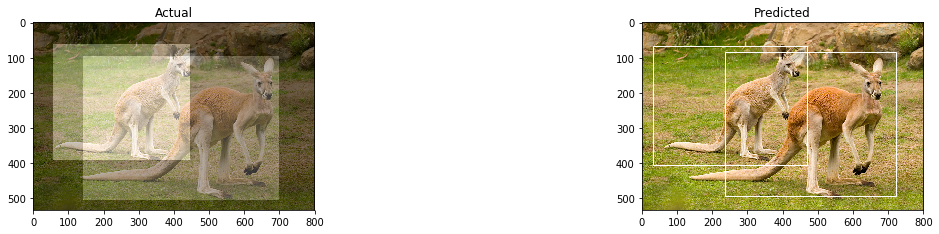

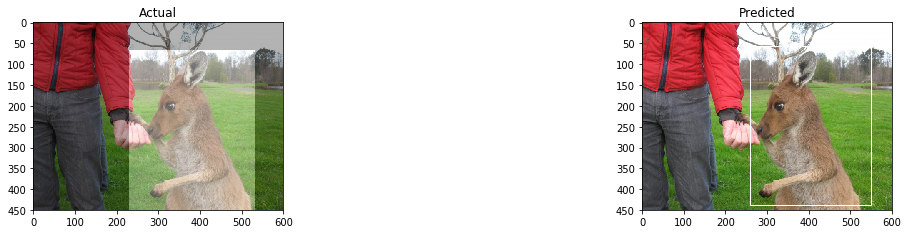

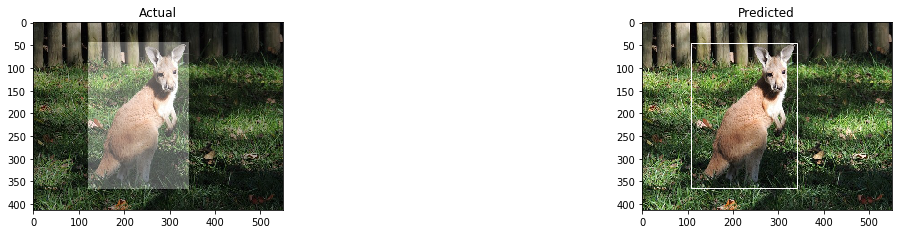

In [0]:
# detect kangaroos in photos with mask rcnn model
 
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        pyplot.figure(figsize=(20,20))
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='white')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.show()

# load the train & test dataset
#load_train()
#load_test()

# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model_path = './kangaroo_cfg20190605T1639/mask_rcnn_kangaroo_cfg_0005.h5'
model.load_weights(model_path, by_name=True)
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)